In [145]:
import numpy as np
import pandas as pd

In [146]:
import matplotlib.pyplot as plt

In [147]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                           f1_score, roc_auc_score, confusion_matrix, 
                           classification_report, precision_recall_curve, auc,
                           roc_curve)
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import entropy

In [148]:
import warnings
warnings.filterwarnings('ignore')


In [149]:
# Set random seed (using last 4 digits of student ID)
RANDOM_SEED = 5117
np.random.seed(RANDOM_SEED)


In [ ]:
# Set style for visualizations
sns.set_style("whitegrid")
plt.style.use('ggplot')

In [151]:
# Set probability threshold for PASS classification
PASS_THRESHOLD = 0.4  # Clients with probabilities between 0.4-0.6 will be classified as PASS


### 加载数据函数

In [152]:
def load_data(filepath):
    """Load and preprocess the data with proper handling of missing values"""
    df = pd.read_csv(filepath, na_values=['.', ' ', ''])
    df = df.dropna(how='all')
    
    # Create target variable with three classes (GOOD=1, BAD=0, PASS=0.5)
    df['target'] = np.where(df['GOOD'] == 1, 2, 
                           np.where(df['BAD'] == 1, 0, 1))
    
    return df


### 数据清洗函数

In [153]:
def clean_data(df):
    """Clean and preprocess the data with proper encoding of categorical variables"""
    numeric_cols = ['cust_age', 'time_emp', 'disp_income', 'S_01', 'S_02', 
                   'CA_02', 'CA_03', 'ER_01', 'ER_02', 'P_01']
    
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors='coerce')
            if col == 'time_emp':
                df[col] = np.where(df[col] > 100, np.nan, df[col])
    
    cat_cols = ['occ_code', 'res_indicator', 'CA_01']
    label_encoders = {}
    
    for col in cat_cols:
        if col in df.columns:
            df[col] = df[col].fillna('Unknown').astype(str)
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col])
            label_encoders[col] = le
    
    if 'CA_01' in df.columns:
        df['CA_01'] = pd.to_numeric(df['CA_01'], errors='coerce')
        df['CA_01'] = df['CA_01'].fillna(0).astype(int)
    
    return df


### 特征工程函数

In [154]:
def feature_engineering(df):
    """Create meaningful features for credit default prediction"""
    if 'disp_income' in df.columns and 'cust_age' in df.columns:
        df['income_to_age_ratio'] = df['disp_income'] / (df['cust_age'].replace(0, 1) + 1)
    
    if 'time_emp' in df.columns and 'cust_age' in df.columns:
        df['employment_ratio'] = df['time_emp'] / (df['cust_age'] - 18 + 1)
    
    df['age_group'] = pd.cut(df['cust_age'], 
                           bins=[0, 25, 35, 45, 55, 100],
                           labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    if 'disp_income' in df.columns:
        try:
            df['income_group'] = pd.qcut(df['disp_income'], q=5, duplicates='drop',
                                      labels=['very_low', 'low', 'medium', 'high', 'very_high'])
        except:
            df['income_group'] = pd.cut(df['disp_income'], bins=5,
                                      labels=['very_low', 'low', 'medium', 'high', 'very_high'])
    
    df = df.replace([np.inf, -np.inf], np.nan)
    return df


### 数据准备函数

In [155]:
def prepare_data(df):
    """Prepare data for modeling with proper validation checks"""
    if len(df) == 0:
        raise ValueError("No samples with target values after preprocessing.")
    
    drop_cols = ['app_id', 'GOOD', 'BAD', 'target', 'app_date']
    X = df.drop([col for col in drop_cols if col in df.columns], axis=1)
    y = df['target']
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y)
    
    return X_train, X_test, y_train, y_test


### 构建预处理管道

In [156]:
def build_preprocessor():
    """Build preprocessing pipeline"""
    numeric_features = ['cust_age', 'time_emp', 'disp_income', 
                       'S_01', 'S_02', 'CA_02', 'CA_03', 
                       'ER_01', 'ER_02', 'P_01',
                       'income_to_age_ratio', 'employment_ratio']
    
    categorical_features = ['occ_code', 'res_indicator', 'CA_01', 
                           'age_group', 'income_group']
    
    numeric_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])
    
    categorical_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    
    return preprocessor


### 置信度计算函数

In [157]:
def calculate_confidence(predictions):
    """Calculate confidence scores based on prediction probabilities"""
    # Confidence is 1 - normalized entropy of the probability distribution
    confidences = []
    for prob in predictions:
        if len(prob) == 2:  # Binary case
            ent = entropy([prob[0], prob[1]])
            max_ent = np.log(2)  # Maximum entropy for binary distribution
        else:  # Multiclass case
            ent = entropy(prob)
            max_ent = np.log(len(prob))  # Maximum entropy for n-class distribution
        normalized_ent = ent / max_ent
        confidence = 1 - normalized_ent
        confidences.append(confidence)
    return np.array(confidences)


### 模型评估函数

In [158]:
def evaluate_model(model, X_test, y_test):
    """Comprehensive model evaluation with visualizations"""
    # Get probabilities for each class
    y_proba = model.predict_proba(X_test)
    
    # Extract probability of GOOD class (class 2)
    y_proba_good = y_proba[:, 2]  # GOOD is now class 2
    
    # Calculate confidence scores
    confidences = calculate_confidence(y_proba)
    
    # Three-class predictions (GOOD=2, BAD=0, PASS=1)
    y_pred_3class = np.where(
        y_proba_good > (0.5 + PASS_THRESHOLD/2), 2,
        np.where(
            y_proba_good < (0.5 - PASS_THRESHOLD/2), 0, 1
        )
    )
    
    # Binary predictions (GOOD=2 mapped to 1, BAD=0)
    y_pred_binary = np.where(y_proba_good > 0.5, 1, 0)
    
    # Filter out PASS cases (class 1) for binary evaluation
    binary_mask = y_test != 1
    y_test_binary = y_test[binary_mask]
    y_pred_binary_filtered = y_pred_binary[binary_mask]
    y_proba_good_filtered = y_proba_good[binary_mask]
    
    # Map GOOD (2) to 1 for binary evaluation
    y_test_binary = np.where(y_test_binary == 2, 1, y_test_binary)
    
    # Calculate metrics for binary classification (excluding PASS cases)
    accuracy = accuracy_score(y_test_binary, y_pred_binary_filtered)
    precision = precision_score(y_test_binary, y_pred_binary_filtered)
    recall = recall_score(y_test_binary, y_pred_binary_filtered)
    f1 = f1_score(y_test_binary, y_pred_binary_filtered)
    roc_auc = roc_auc_score(y_test_binary, y_proba_good_filtered)
    
    # Confusion Matrix for 3-class
    cm = confusion_matrix(y_test, y_pred_3class, labels=[0, 1, 2])
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Predicted BAD', 'Predicted PASS', 'Predicted GOOD'], 
                yticklabels=['Actual BAD', 'Actual PASS', 'Actual GOOD'])
    plt.title('Confusion Matrix (3-class)')
    plt.show()
    
    # ROC Curve (binary)
    if len(np.unique(y_test_binary)) > 1:
        fpr, tpr, _ = roc_curve(y_test_binary, y_proba_good_filtered)
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve (Binary Classification)')
        plt.legend()
        plt.show()
    
    # Precision-Recall Curve
    precision_vals, recall_vals, _ = precision_recall_curve(y_test_binary, y_proba_good_filtered)
    pr_auc = auc(recall_vals, precision_vals)
    plt.figure(figsize=(8, 6))
    plt.plot(recall_vals, precision_vals, label=f'PR Curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve (Binary Classification)')
    plt.legend()
    plt.show()
    
    # Feature Importance (关键修复点)
    # 从校准模型的第一个分类器中提取基分类器
    pipeline = model.calibrated_classifiers_[0].estimator  # 使用 estimator 而非 base_estimator
    feature_importance = pd.DataFrame({
        'feature': pipeline.named_steps['preprocessor'].get_feature_names_out(),
        'importance': pipeline.named_steps['classifier'].feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', 
               data=feature_importance.head(20))
    plt.title('Top 20 Important Features')
    plt.tight_layout()
    plt.show()
    
    # Probability distribution plot
    plt.figure(figsize=(10, 6))
    sns.histplot(y_proba_good, bins=30, kde=True)
    plt.axvline(x=0.5 - PASS_THRESHOLD/2, color='r', linestyle='--', label='PASS threshold')
    plt.axvline(x=0.5 + PASS_THRESHOLD/2, color='r', linestyle='--')
    plt.xlabel('Probability of being GOOD')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Probabilities')
    plt.legend()
    plt.show()
    
    print("\nModel Performance (Binary Classification - excluding PASS cases):")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    
    # Calculate PASS rate
    pass_rate = np.mean(y_pred_3class == 1)
    print(f"\nPASS Rate: {pass_rate:.2%} of cases were classified as PASS")
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pass_rate': pass_rate,
        'feature_importance': feature_importance,
        'probabilities': y_proba_good,
        'confidences': confidences
    }

### 模型训练函数

In [159]:
def train_model(X_train, X_test, y_train, y_test, preprocessor):
    """Train and evaluate the model"""
    # Convert 3-class target to binary for training (PASS cases will be excluded)
    binary_mask = y_train != 0.5
    X_train_binary = X_train[binary_mask]
    y_train_binary = y_train[binary_mask].astype(int)
    
    pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(
            random_state=RANDOM_SEED,
            class_weight='balanced',
            n_estimators=200,
            max_depth=12,
            min_samples_split=5
        ))
    ])
    
    # Wrap the classifier with calibration to get better probability estimates
    calibrated_model = CalibratedClassifierCV(pipeline, cv=5, method='isotonic')
    
    calibrated_model.fit(X_train_binary, y_train_binary)
    results = evaluate_model(calibrated_model, X_test, y_test)
    
    return calibrated_model, results


### 数据可视化函数

In [163]:
def visualize_data(df):
    """Create exploratory data visualizations"""
    # Target distribution
    plt.figure(figsize=(8, 6))
    target_counts = df['target'].value_counts()
    sns.barplot(x=['BAD', 'PASS', 'GOOD'], y=[target_counts.get(0, 0), target_counts.get(0.5, 0), target_counts.get(1, 0)])
    plt.title('Distribution of Target Variable')
    
    plt.ylabel('Count')
    plt.show()
    
    # Age distribution by target
    plt.figure(figsize=(10, 6))
    sns.histplot(data=df, x='cust_age', hue='target', 
                 bins=30, kde=True, multiple='stack')
    plt.title('Age Distribution by Target')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.legend(['BAD', 'PASS', 'GOOD'])
    plt.show()
    
    # Income distribution
    if 'disp_income' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y='disp_income', data=df)
        plt.title('Income Distribution by Target')
        
        plt.yscale('log')  # Log scale due to wide income range
        plt.show()
    
    # Employment duration
    if 'time_emp' in df.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='target', y='time_emp', data=df)
        plt.title('Employment Duration by Target')
        
        plt.show()
    
    # Correlation matrix for numeric features
    numeric_cols = ['cust_age', 'time_emp', 'disp_income', 'S_01', 'S_02', 
                   'CA_02', 'CA_03', 'ER_01', 'ER_02', 'P_01', 'target']
    numeric_cols = [col for col in numeric_cols if col in df.columns]
    
    plt.figure(figsize=(12, 10))
    sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Numeric Features')
    plt.show()


### 主程序入口

In [161]:
def main():
    try:
        # 1. Load data
        print("Loading data...")
        df = load_data('P2data5117.csv')
        print(f"Initial data shape: {df.shape}")
        
        # 2. Clean data
        print("Cleaning data...")
        df_clean = clean_data(df)
        print(f"Data shape after cleaning: {df_clean.shape}")
        
        # 3. Feature engineering
        print("Performing feature engineering...")
        df_fe = feature_engineering(df_clean)
        df_fe.to_csv('data_cleaned.csv', index=False)
        print(f"Data shape after feature engineering: {df_fe.shape}")
        
        # 4. Data visualization
        print("Creating exploratory visualizations...")
        visualize_data(df_fe)
        
        # 5. Prepare modeling data
        print("Preparing data for modeling...")
        X_train, X_test, y_train, y_test = prepare_data(df_fe)
        print(f"Training samples: {len(X_train)}, Test samples: {len(X_test)}")
        
        # 6. Build preprocessing pipeline
        print("Building preprocessing pipeline...")
        preprocessor = build_preprocessor()
        
        # 7. Train and evaluate model
        print("Training and evaluating model...")
        model, results = train_model(X_train, X_test, y_train, y_test, preprocessor)
        
        print("\nFinal Recommendation:")
        print("Based on the evaluation metrics, we recommend deploying the Random Forest model with the following approach:")
        print("1. Three-class classification (GOOD, BAD, PASS) where:")
        print(f"   - GOOD if probability > {0.5 + PASS_THRESHOLD/2:.2f}")
        print(f"   - BAD if probability < {0.5 - PASS_THRESHOLD/2:.2f}")
        print(f"   - PASS otherwise (uncertain cases)")
        print(f"2. Current PASS rate: {results['pass_rate']:.2%} of cases need further review")
        print("\nModel performance on clear cases (GOOD/BAD):")
        print(f"- ROC AUC: {results['roc_auc']:.4f}")
        print(f"- Accuracy: {results['accuracy']:.4f}")
        print(f"- Precision: {results['precision']:.4f}")
        print(f"- Recall: {results['recall']:.4f}")
        print(f"- F1 Score: {results['f1']:.4f}")
        
        # Create a sample output dataframe with predictions and confidence
        sample_output = X_test.copy()
        sample_output['True_Label'] = y_test
        sample_output['Predicted_Probability'] = results['probabilities']
        sample_output['Predicted_Class'] = np.where(results['probabilities'] > (0.5 + PASS_THRESHOLD/2), 'GOOD',
                                                  np.where(results['probabilities'] < (0.5 - PASS_THRESHOLD/2), 'BAD', 'PASS'))
        sample_output['Confidence'] = results['confidences']
        
        print("\nSample predictions with confidence scores:")
        print(sample_output[['True_Label', 'Predicted_Probability', 'Predicted_Class', 'Confidence']].head(10))
        
        return model, results
        
    except Exception as e:
        print(f"Error occurred: {str(e)}")
        return None, None


### 主程序入口

Loading data...
Initial data shape: (9289, 26)
Cleaning data...
Data shape after cleaning: (9289, 26)
Performing feature engineering...
Data shape after feature engineering: (9289, 30)
Creating exploratory visualizations...


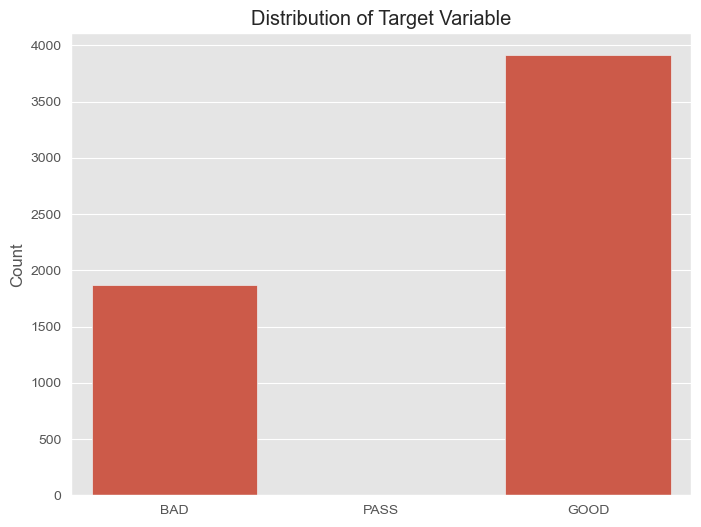

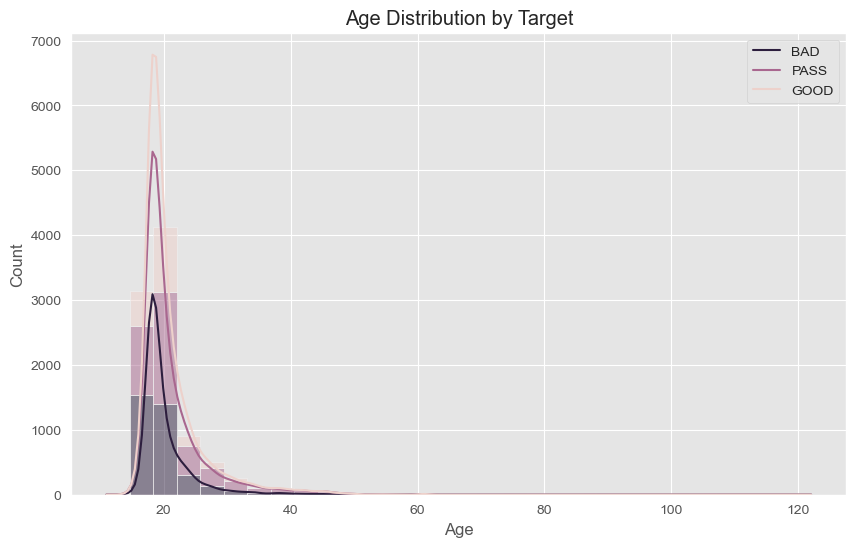

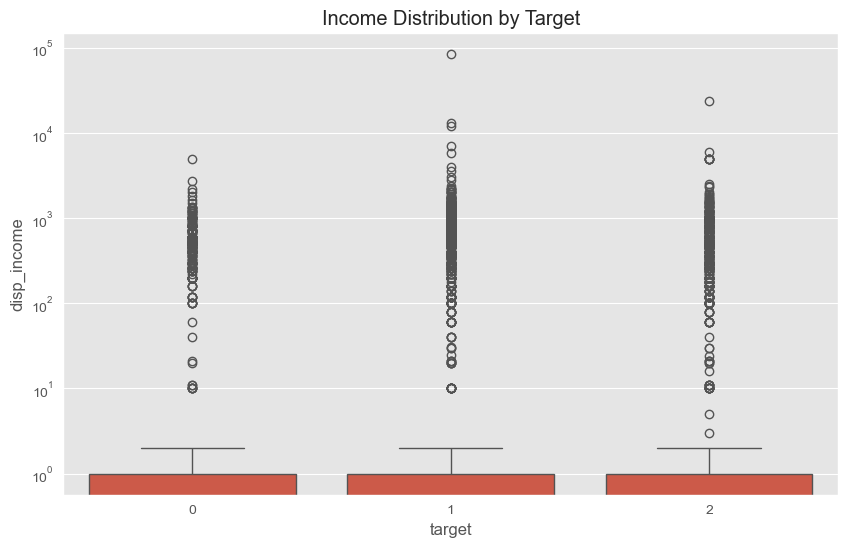

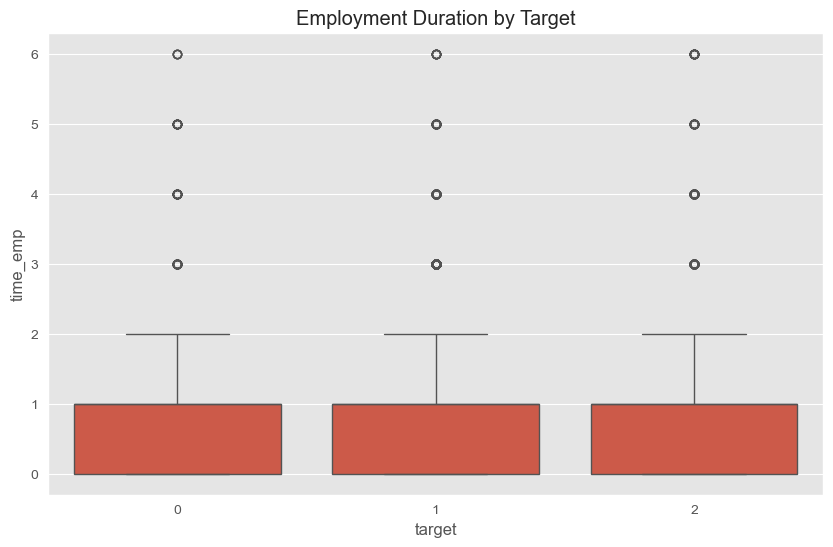

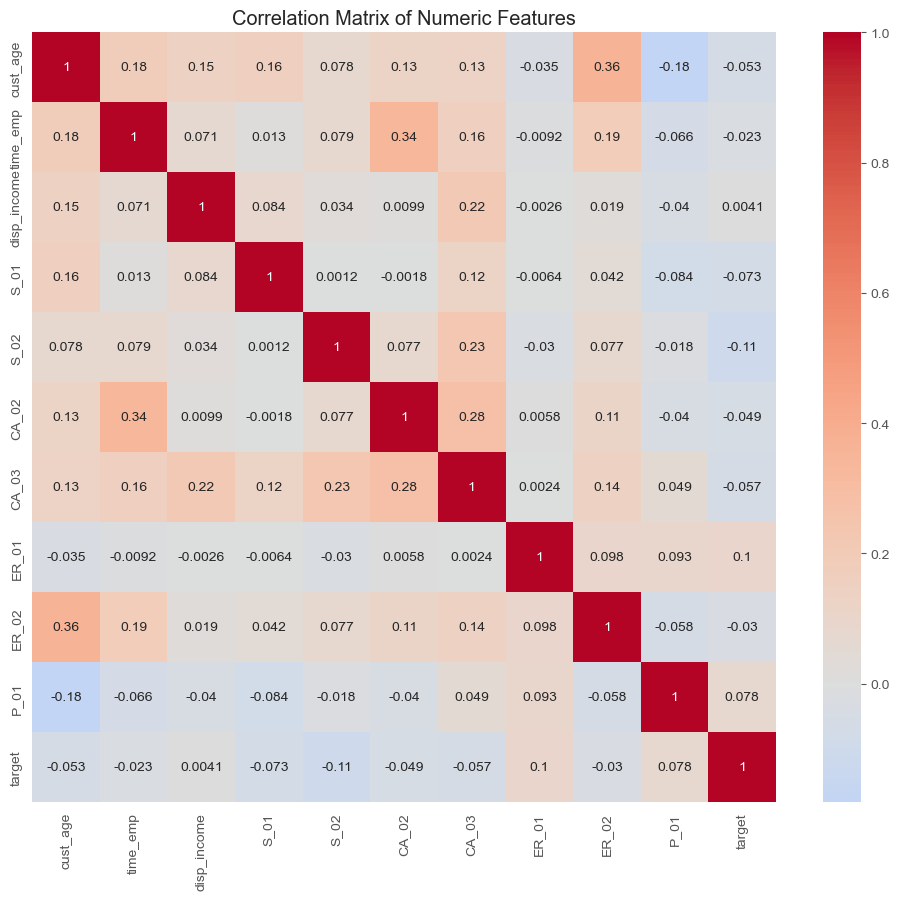

Preparing data for modeling...
Training samples: 6502, Test samples: 2787
Building preprocessing pipeline...
Training and evaluating model...


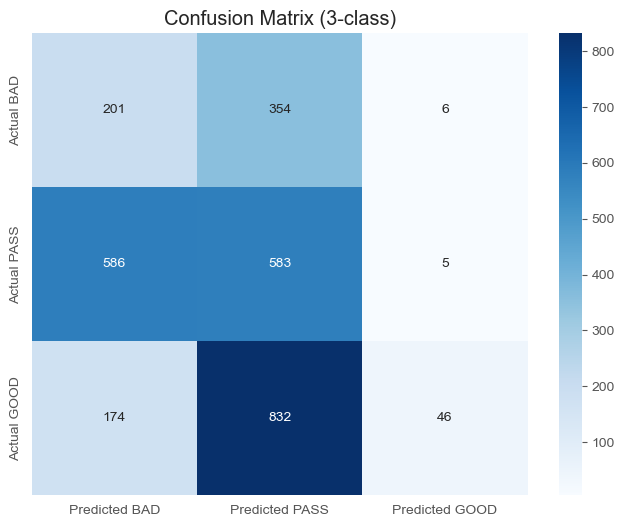

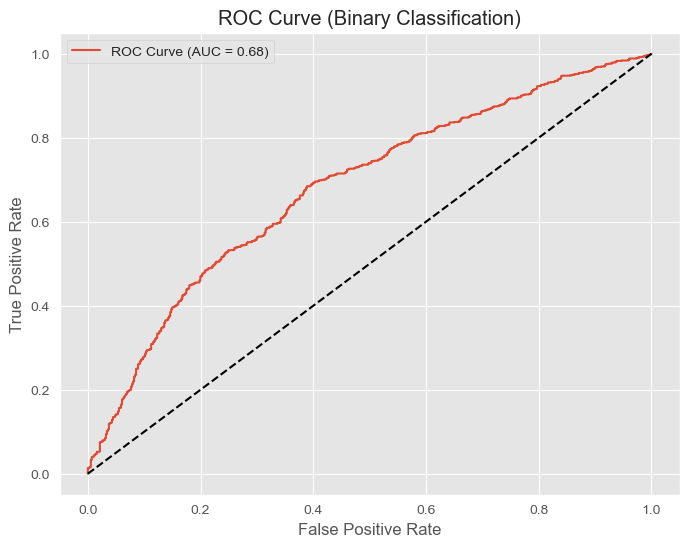

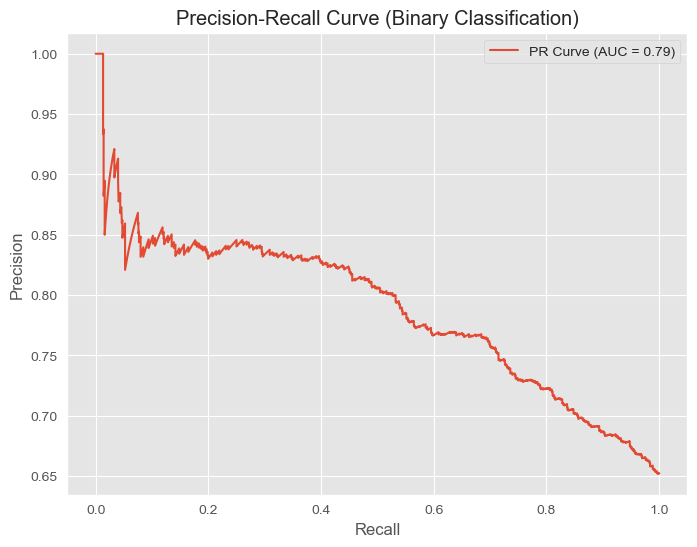

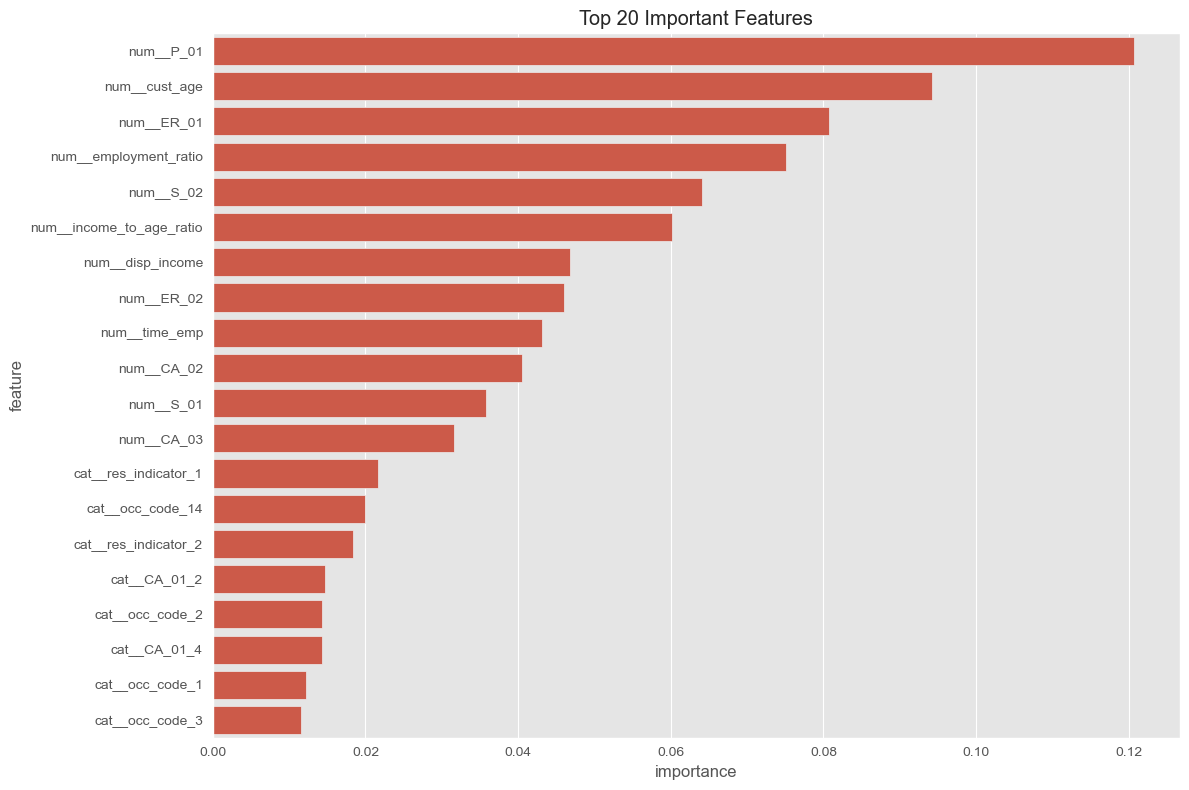

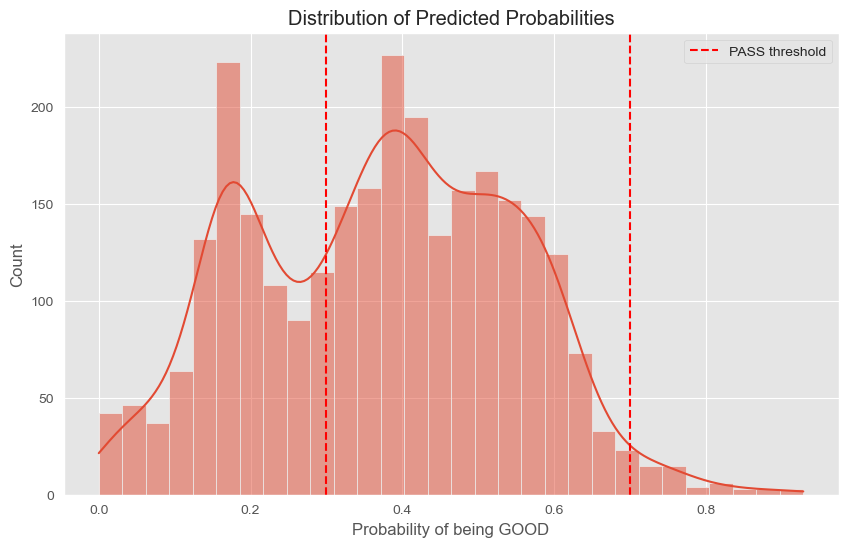


Model Performance (Binary Classification - excluding PASS cases):
Accuracy: 0.5679
Precision: 0.8221
Recall: 0.4306
F1 Score: 0.5652
ROC AUC: 0.6817

PASS Rate: 63.47% of cases were classified as PASS

Final Recommendation:
Based on the evaluation metrics, we recommend deploying the Random Forest model with the following approach:
1. Three-class classification (GOOD, BAD, PASS) where:
   - GOOD if probability > 0.70
   - BAD if probability < 0.30
   - PASS otherwise (uncertain cases)
2. Current PASS rate: 63.47% of cases need further review

Model performance on clear cases (GOOD/BAD):
- ROC AUC: 0.6817
- Accuracy: 0.5679
- Precision: 0.8221
- Recall: 0.4306
- F1 Score: 0.5652

Sample predictions with confidence scores:
       True_Label  Predicted_Probability Predicted_Class  Confidence
12679           1               0.130756             BAD    0.335799
12825           2               0.588384            PASS    0.152883
12667           2               0.467594            PASS    0.

In [162]:
if __name__ == "__main__":
    model, results = main()